<a href="https://colab.research.google.com/github/zenilist/DataAnalytics/blob/main/A_Kar_Quiz4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction and Data Summary**

In this assignment our task is to work on the Home Mortgage Disclosure Act data set sourced from the Federal Reserve Bank of Boston. The contents for the dataset can be found [here](https://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/Hdma.html).

Our primary goal is to contruct and compare a series of binary logistic regression models that would predict whether or not a given mortgage appication is likely to be denied. The response variable is "**DENY"**.

Our road map would look this this:
1. Load data set from github using pandas dataframe.
2. Perform EDA work to get useful statistics of the given attributes.
3. Perform Data Preparation work to transform the raw data if needed.
4. Use various techniques to decide which variables to keep and/or discard.
5. After the data has been cleaned we would divide the dataset into two sets - training and testing. We would use the training subset to create three binary regression models.
6. We would then test those models and compare against each other to decide which one to keep based on different metrics like accuracy, complexity, performance. 



##**Data Attributes:**

| Attribute name | Attribute Description                                                                                 |   |   |   |
|----------------|-------------------------------------------------------------------------------------------------------|---|---|---|
| dir            | debt payments to total income ratio                                                                   |   |   |   |
| hir            | housing expenses to income ratio                                                                      |   |   |   |
| lvr            | ratio of size of loan to assessed value of property                                                   |   |   |   |
| ccs            | consumer credit score from 1 to 6 (a low value being a good score)                                    |   |   |   |
| mcs            | mortgage credit score from 1 to 4 (a low value being a good score)                                    |   |   |   |
| pbcr           | public bad credit record ?                                                                            |   |   |   |
| dmi            | denied mortgage insurance ?                                                                           |   |   |   |
| self           | self employed ?                                                                                       |   |   |   |
| single         | is the applicant single ?                                                                             |   |   |   |
| uria           | 1989 Massachusetts unemployment rate in the applicant's industry                                      |   |   |   |
| condominium    | is unit a condominium ? (was called comdominiom in version 0.2-9 and earlier versions of the package) |   |   |   |
| black          | is the applicant black?                                                                               |   |   |   |
| deny           | mortgage application denied ?                                                                         |   |   |   |

#**Data Loading**

In [216]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from yellowbrick.classifier import ROCAUC
from yellowbrick.target import FeatureCorrelation
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score

#load dataset
df = pd.read_csv("https://raw.githubusercontent.com/zenilist/DataAnalytics/main/HDMA%20Boston%20Housing%20Data.csv", index_col=0)
#check first few rows
df.head()

,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


In [217]:
#check the dimensions
df.shape

(2381, 13)

In [218]:
#check if there is any null data
df.isnull().sum()


dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           1
dmi            0
self           1
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

In [219]:
#check which index has null value
#source code: https://stackoverflow.com/questions/14016247/find-integer-index-of-rows-with-nan-in-pandas-dataframe
print("Index for pbcr: ",df.loc[pd.isna(df["pbcr"]), :].index)
print("Index for self: ",df.loc[pd.isna(df["self"]), :].index)

Index for pbcr:  Int64Index([2381], dtype='int64')
Index for self:  Int64Index([2381], dtype='int64')


This is interesting, both the NaN values are from the last row in the data frame.

In [220]:
#check unique value for each variable 
df.nunique()

dir             520
hir             501
lvr            1538
ccs               7
mcs               5
pbcr              2
dmi               2
self              2
single            2
uria             11
comdominiom       2
black             2
deny              2
dtype: int64

mcs has values 1-4, so there should only be 4 values but there is an extra one.
same with ccs which is on a scale of 1-6 but has 7 unique values. Good thing to take note of.

*edit: after checking the last row of the data it seems that there are two values with decimals.*

All other variables are in the expected range.

In [221]:
#check data type of each variable
df.dtypes

dir            float64
hir            float64
lvr            float64
ccs            float64
mcs            float64
pbcr            object
dmi             object
self            object
single          object
uria           float64
comdominiom      int64
black           object
deny            object
dtype: object

Data types appear to be alright, requires no transformation.

#**Exploratory Data Analysis**

In this section we would use our skills as a data practioner to make meaningful connections between different variables gain vital insights from various graphs.

##**Numeric Variables**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94f453d350>,
      dtype=object)

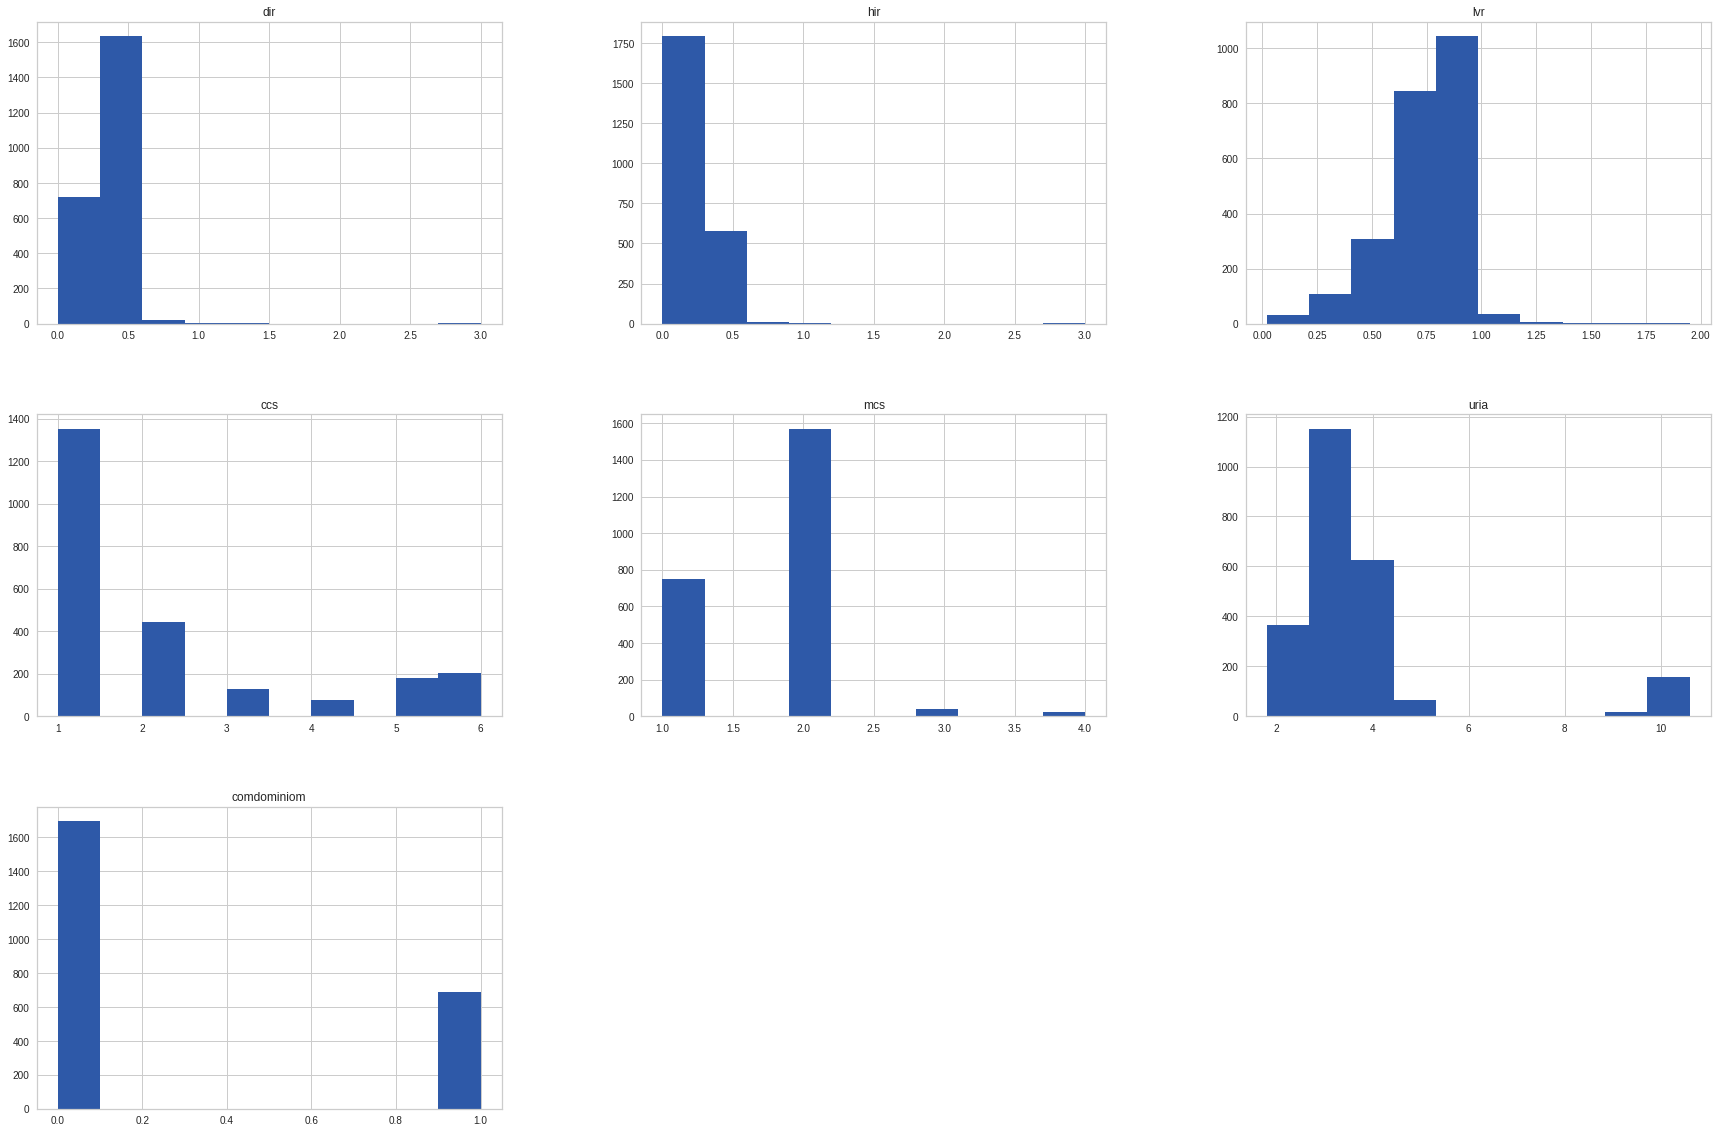

In [222]:
df.hist(figsize=(30,20), color='#2e59a8')

* Almost 70% of the sample size have debt payments that is around 25-60% of their total income. There is a marginal group of people who have debt payments three times their income.
* Housing payments ratio have outliers that mirror the distribution of dir. A fair question would be to ask if the people with dir>1 are in that position due to their housing payments.
* Majority of loans are worth 60-95% of their property value. Some loans are worth more than 100% of the property value going as far as 1.8x. This might indicate that the value of the property has greatly fallen and/or interest accumulation from high interest loans. [for more info](https://www.quickenloans.com/learn/negative-equity#:~:text=Negative%20equity%20happens%20when%20you,values%20and%20high-interest%20loans.).
* Around 200 people work in indusries with a high unemployemt rate of around 10%.

In [223]:
#statistics of numeric variables
df.describe()

,dir,hir,lvr,ccs,mcs,uria,comdominiom
count,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,0.330814,0.255346,0.737760,2.116387,1.721008,3.774496,0.288114
std,0.107235,0.096635,0.178715,1.666370,0.537169,2.026636,0.452980
min,0.000000,0.000000,0.020000,1.000000,1.000000,1.800000,0.000000
25%,0.280000,0.214000,0.652850,1.000000,1.000000,3.100000,0.000000
50%,0.330000,0.260000,0.779412,1.000000,2.000000,3.200000,0.000000
75%,0.370000,0.298800,0.868421,2.000000,2.000000,3.900000,1.000000
max,3.000000,3.000000,1.950000,6.000000,4.000000,10.600000,1.000000


* The average and median unemployement rate for each industry appear to be normal.
* It is odd that there is a zero dir and hir but lvr is .02. Is is safe to assume that if all three of the minimum values belong to the same person, then 


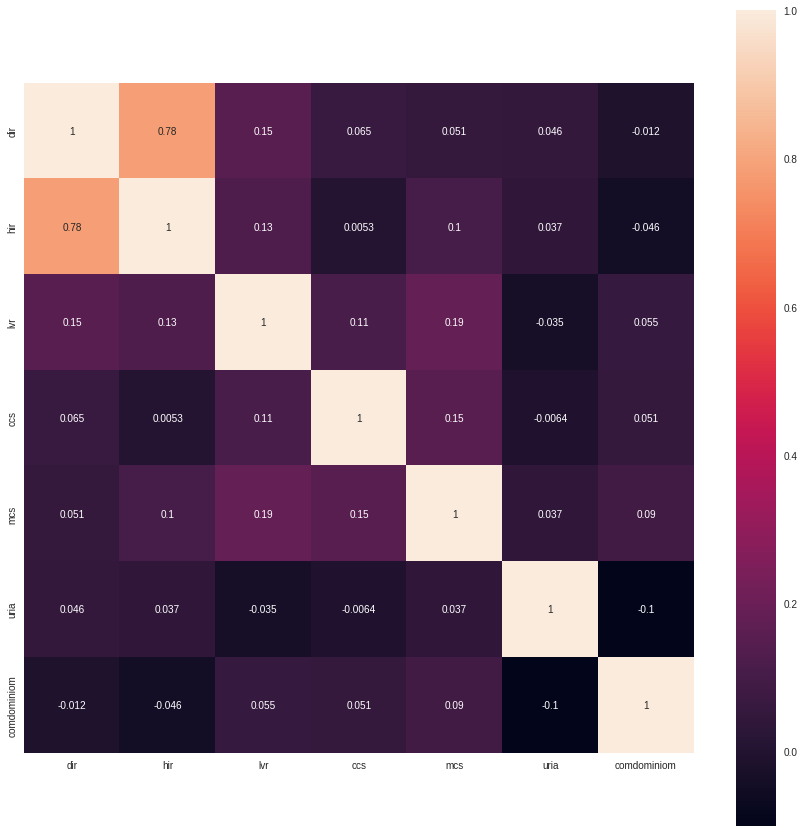

In [224]:
#correlation heatmap
corr = df.corr()
ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=corr, square=True , annot=True, cbar=True)

Not much correlation between the variables except for debt payment ratio and housing expense ratio being strongly related.

##**Categorical Variables**

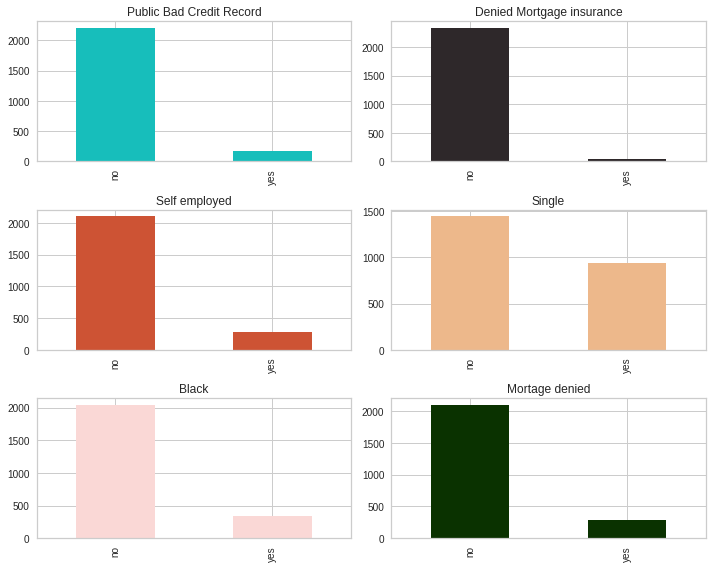

In [225]:
#Frequency of categorical variables

plt.figure(1)
plt.subplot(321)
df['pbcr'].value_counts().plot(figsize=(10,8),kind='bar',color='#17bebb')
plt.title("Public Bad Credit Record")



plt.subplot(322)
df['dmi'].value_counts().plot(figsize=(10,8),kind='bar',color='#2E282A')
plt.title("Denied Mortgage insurance")


plt.subplot(323)
df['self'].value_counts().plot(figsize=(10,8),kind='bar',color='#CD5334')
plt.title("Self employed")


plt.subplot(324)
df['single'].value_counts().plot(figsize=(10,8),kind='bar',color='#EDB88B')
plt.title("Single")


plt.subplot(325)
df['black'].value_counts().plot(figsize=(10,8),kind='bar',color='#FAD8D6')
plt.title("Black")


plt.subplot(326)
df['deny'].value_counts().plot(figsize=(10,8),kind='bar',color='#0A3200')
plt.title("Mortage denied")

plt.tight_layout()
plt.show()

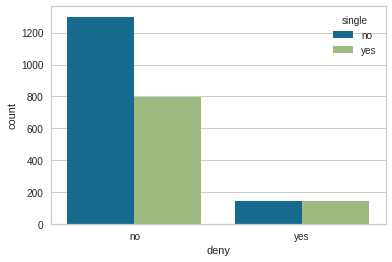

In [226]:
sns.countplot(data=df, x='deny',hue='single')

Being single seems to have a positive correlation with getting one's mortagage application denied.

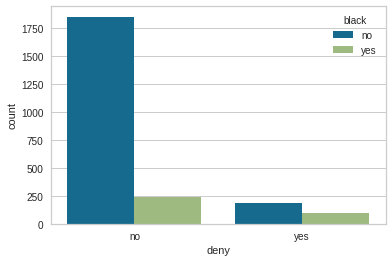

In [227]:
sns.countplot(data=df, x='deny',hue='black')

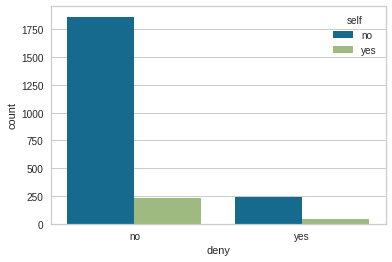

In [228]:
sns.countplot(data=df, x='deny',hue='self')

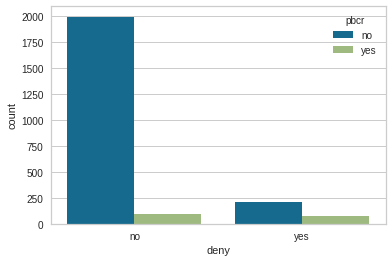

In [229]:
sns.countplot(data=df, x='deny',hue='pbcr')

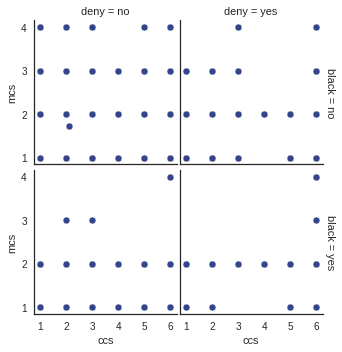

In [230]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df, row="black", col="deny", margin_titles=True, height=2.5)
g.map(sns.scatterplot, "ccs", "mcs", color="#334488")
g.set_axis_labels("ccs", "mcs")
g.set(xticks=[1, 2, 3, 4, 5, 6], yticks=[1, 2, 3, 4])
g.figure.subplots_adjust(wspace=.02, hspace=.04)

Some non black applicants who have a bad mcs are decent ccs (1-3) are given mortgages but this does not say much since there are no black applicats with bad mcs(4) and decent ccs.
In summary, race does not appear to be a good predictor when mortgage credit score and consumer credit score are taken into consideration. Because the number of black applicants are a lot lower than non black applicants, the observations might not be entirely accurate.

#**Data Preparation**

##**Missing Data**

In [231]:
#use mode to fill in missing data

df = df.fillna(df.mode().iloc[0])
df.isnull().sum()

dir            0
hir            0
lvr            0
ccs            0
mcs            0
pbcr           0
dmi            0
self           0
single         0
uria           0
comdominiom    0
black          0
deny           0
dtype: int64

##**Transform Data**

For logical regression modelling to work smoothly we will change all the variables that have yes/no values to 1/0s.

In [232]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder() 
df['pbcr'] = lb.fit_transform(df['pbcr'])
df['dmi'] = lb.fit_transform(df['dmi'])
df['self'] = lb.fit_transform(df['self'])
df['single'] = lb.fit_transform(df['single'])
df['comdominiom'] = lb.fit_transform(df['comdominiom'])
df['black'] = lb.fit_transform(df['black'])
df['deny'] = lb.fit_transform(df['deny'])
df.dtypes

dir            float64
hir            float64
lvr            float64
ccs            float64
mcs            float64
pbcr             int64
dmi              int64
self             int64
single           int64
uria           float64
comdominiom      int64
black            int64
deny             int64
dtype: object

##**Feature Selection**

Based on our correlation matrix we found that dir and hir are highly correlated, so using that we would filter out one of those features out of our predictive model

In [233]:
df_t = df.copy()
df_t = df_t.drop('hir', axis='columns')
df_t.head()

,dir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
1,0.221,0.800000,5.0,2.0,0,0,0,0,3.9,0,0,0
2,0.265,0.921875,2.0,2.0,0,0,0,1,3.2,0,0,0
3,0.372,0.920398,1.0,2.0,0,0,0,0,3.2,0,0,0
4,0.320,0.860465,1.0,2.0,0,0,0,0,4.3,0,0,0
5,0.360,0.600000,1.0,1.0,0,0,0,0,3.2,0,0,0


#**Prepped Data Review**

Let us run statistics and graphs to compare any change from the raw data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94f3633a90>,
      dtype=object)

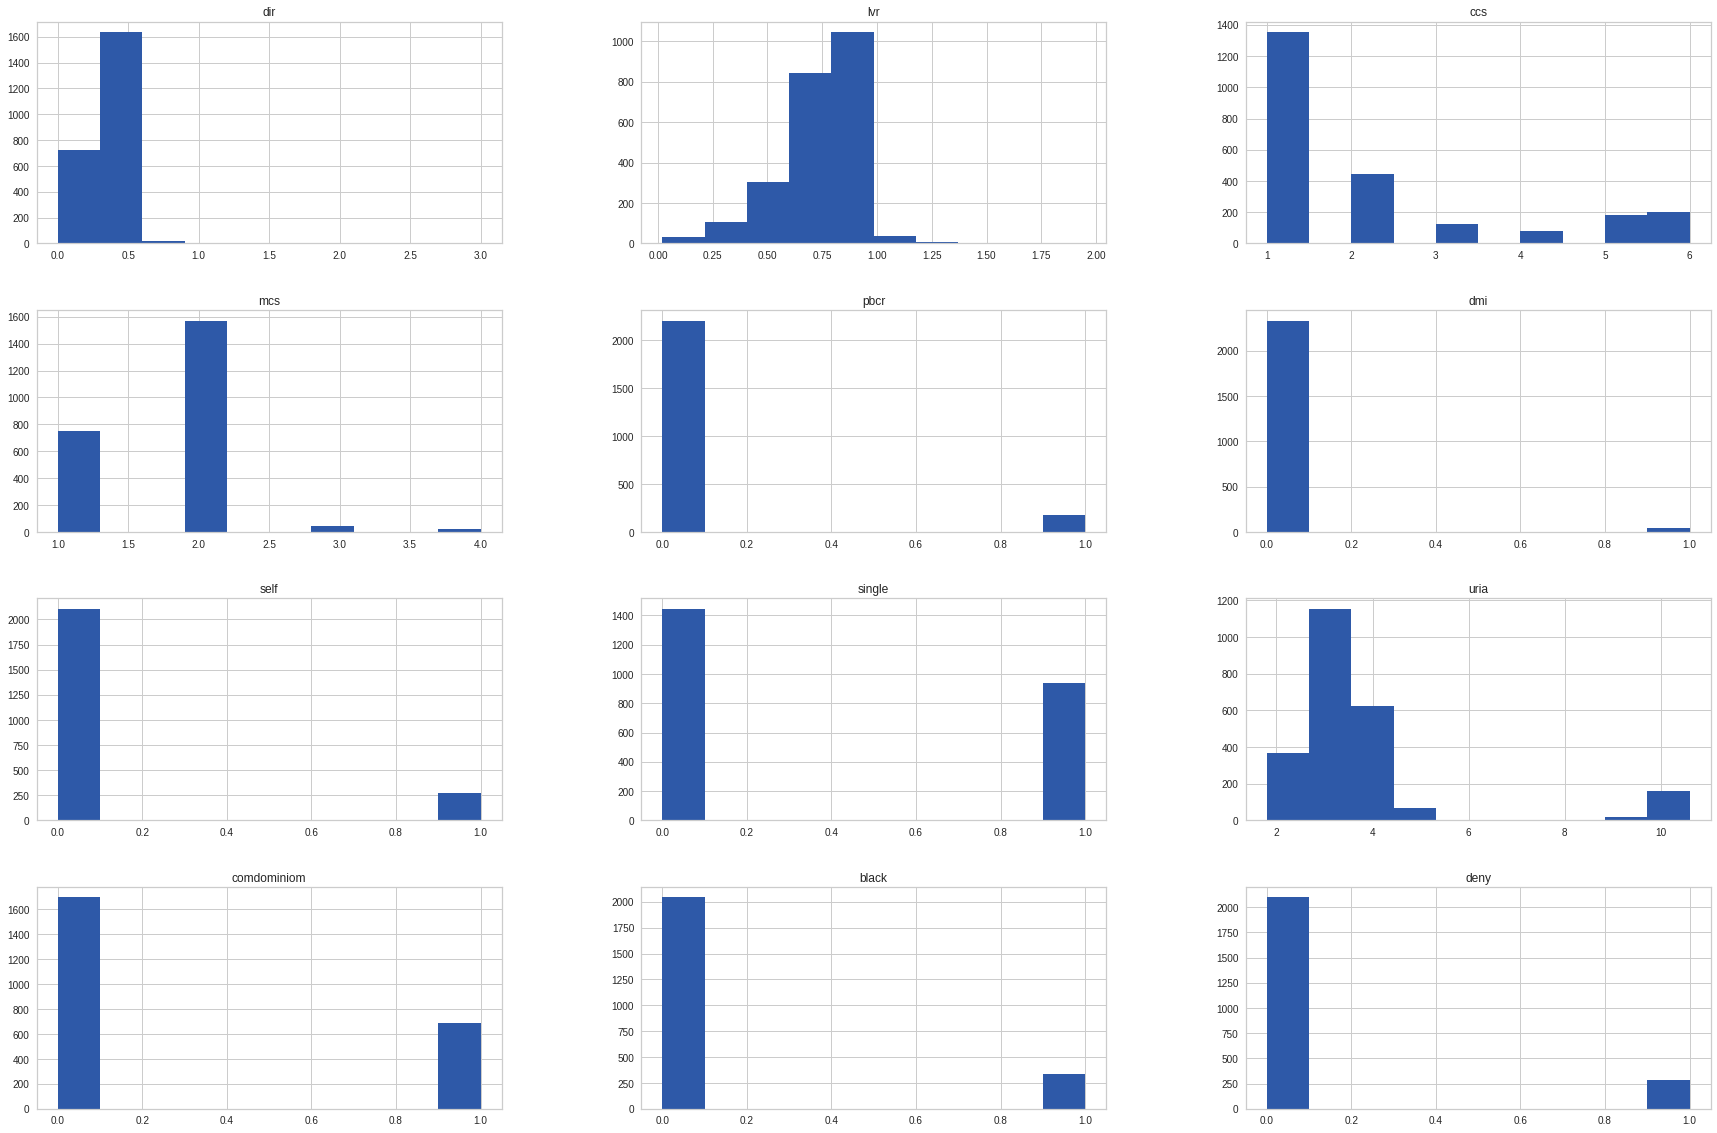

In [234]:
df_t.hist(figsize=(30,20), color='#2e59a8')

In [235]:
df_t.describe()

,dir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
count,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,0.330814,0.737760,2.116387,1.721008,0.073499,0.020160,0.116338,0.393532,3.774496,0.288114,0.142377,0.119698
std,0.107235,0.178715,1.666370,0.537169,0.261008,0.140576,0.320697,0.488636,2.026636,0.452980,0.349510,0.324676
min,0.000000,0.020000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.800000,0.000000,0.000000,0.000000
25%,0.280000,0.652850,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.100000,0.000000,0.000000,0.000000
50%,0.330000,0.779412,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.200000,0.000000,0.000000,0.000000
75%,0.370000,0.868421,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,3.900000,1.000000,0.000000,0.000000
max,3.000000,1.950000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,10.600000,1.000000,1.000000,1.000000


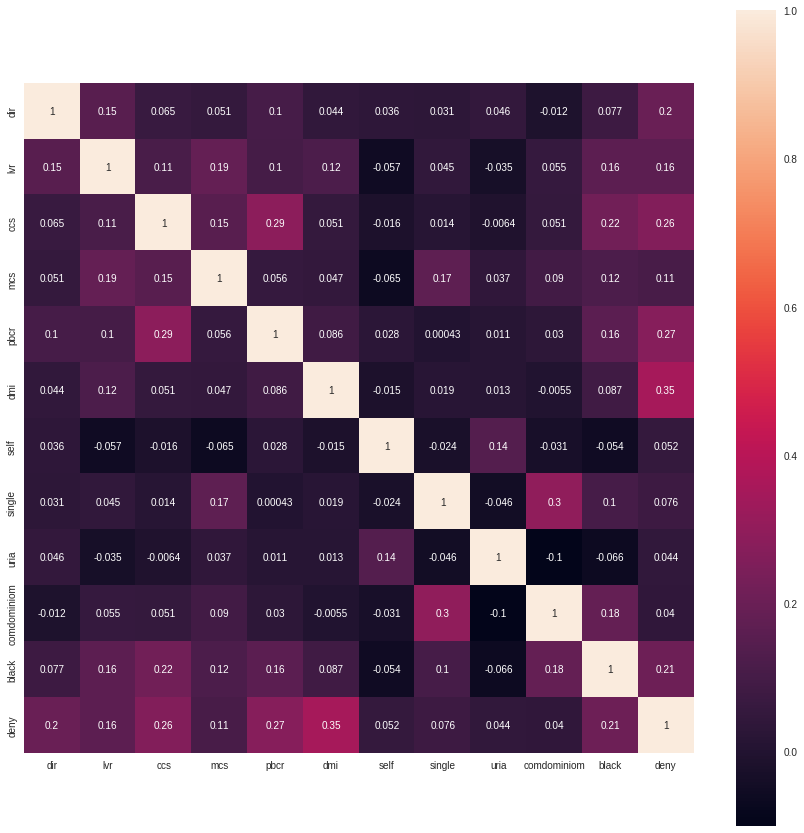

In [236]:
#correlation heatmap
corr = df_t.corr()
ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=corr, square=True , annot=True, cbar=True)

#**Regressing Modeling**

Look at features that give the most information to determine whether an applicant gets denied

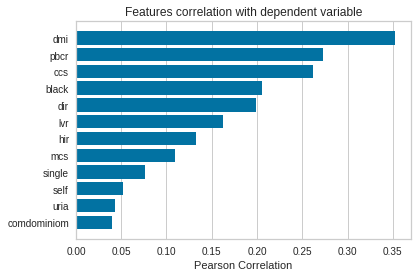

In [237]:
#use yellowbrick to look at feature dependency
#source: https://www.udemy.com/course/python-for-all-with-a-focus-on-financial-applications/learn/lecture/24132044#overview


df_test = df.copy()
target = df_test['deny']
features = df_test.drop('deny', axis=1).copy()
feature_names = list(features.columns)

visualizer = FeatureCorrelation(lables=feature_names,meathod='pearson',sort=True)
visualizer.fit(features,target)
visualizer.poof()

In [238]:
target = df_t['deny']
features = df_t.drop('deny', axis=1).copy()
feature_names = list(features.columns)

selection_kBest = SelectKBest(f_regression, k =5).fit(features,target)


features_kbest = selection_kBest.get_support()
print("Overall features: ", df_t.columns, '\n')
print("Chosen features: ", features.columns[features_kbest],'\n')

selection_kBest.scores_


Overall features:  Index(['dir', 'lvr', 'ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single', 'uria',
       'comdominiom', 'black', 'deny'],
      dtype='object') 

Chosen features:  Index(['dir', 'ccs', 'pbcr', 'dmi', 'black'], dtype='object') 



array([ 98.44180896,  64.31953539, 175.85967302,  28.94913233,
       191.52316913, 336.81573745,   6.40773209,  13.96378611,
         4.52958742,   3.75069692, 104.58732528])

In [239]:
#X is the independant variables and y is the response variable

X = df_t[['dir', 'ccs', 'pbcr', 'dmi', 'black']].to_numpy()
y = df[['deny']].to_numpy()
X

array([[0.221     , 5.        , 0.        , 0.        , 0.        ],
       [0.265     , 2.        , 0.        , 0.        , 0.        ],
       [0.37200001, 1.        , 0.        , 0.        , 0.        ],
       ...,
       [0.32      , 6.        , 1.        , 0.        , 1.        ],
       [0.35      , 2.        , 0.        , 0.        , 0.        ],
       [0.33081357, 2.11638656, 0.        , 0.        , 0.        ]])

In [240]:

#one line code to create the logistic regression model
model = LogisticRegression()
model = model.fit(X,y)

In [241]:
model.score(X,y)


0.9038219235615288

The model has a 90% accuracy rate.

In [242]:
y.mean()

0.11969760604787905

If the prediction model predicts 'no' every time, then the accuracy rate would be 88%.

The improvement we gain by using logistic regression is only 2%.



In [243]:
#coefficents of our model
model.coef_

array([[3.16674417, 0.30085808, 1.24993953, 3.83710579, 0.80367413]])

There is a very high likelihood that the applicant is denied a mortgage if he has been denied before. 
The spread of the coefficents are very similar to the dependency we got while doing feature selection.

#**Model Evaluation**

Reference for code: https://nbviewer.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

In [244]:
#set up train and train cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=0)
model_t = LogisticRegression()
model_t.fit(X_train, y_train)

LogisticRegression()

In [245]:
#predicted result for each applicant, 1-denied, 0-not denied
predicted = model_t.predict(X_test)
print(predicted)

[0 1 0 ... 0 0 0]


In [246]:
probs = model_t.predict_proba(X_test)
print(probs)

[[0.90371405 0.09628595]
 [0.42676518 0.57323482]
 [0.93266374 0.06733626]
 ...
 [0.86213685 0.13786315]
 [0.93209477 0.06790523]
 [0.93257148 0.06742852]]


The model outputs 1(denied) when the second column is > .5.

In [247]:
#Evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.8824049513704686
0.7755205916256231


There is a slight discrepancy of about 2% compared to our initial unsplit model.

In [248]:
print( metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1951   43]
 [ 223   45]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1994
           1       0.51      0.17      0.25       268

    accuracy                           0.88      2262
   macro avg       0.70      0.57      0.59      2262
weighted avg       0.85      0.88      0.86      2262



This logistic regression model gave us a f1 score of .95 for predicting 0 and .40 for predicting 1.

In [249]:
# evaluate the model using 25-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=25)
print(scores)
print(scores.mean())

[0.92708333 0.90625    0.88541667 0.84375    0.86458333 0.91666667
 0.91578947 0.91578947 0.93684211 0.93684211 0.91578947 0.91578947
 0.89473684 0.89473684 0.87368421 0.90526316 0.90526316 0.91578947
 0.94736842 0.90526316 0.89473684 0.89473684 0.89473684 0.89473684
 0.89473684]
0.9038552631578948


The model seems to be hovering around the 90% accuracy range which indicates that our model is working.

#**Concluding statements**

*Let's ask an interesting question to the model:*
Does **race** play an important role in determining if the applicant is **denied**?

Situation 1:
A non- black applicant that has zero debt payment, a perfect consumer credit score, and has not been denied mortage previously- (best case)

In [250]:
#dir,ccs,pbcr,dmi,black
model.predict_proba([[0,1,0,0,0]])

array([[0.98255027, 0.01744973]])

We get a probability of 98.25% that he gets the mortgage based on our model.

Situation 2: All parameters would stay the same, except if the applicant was black- (best case)

In [251]:
#
#dir,ccs,pbcr,dmi,black
model.predict_proba([[0,1,0,0,1]])

array([[0.96184342, 0.03815658]])

There is a 96.18% probability that he gets the mortgage.

Situation 3: A non- black applicant that has debt payments equaling total income, bad consumer credit score, and has been denied mortage previously- (worst case).

In [252]:
##dir,ccs,pbcr,dmi,black
model.predict_proba([[1,6,1,1,0]])

array([[0.00324544, 0.99675456]])

Probability that he gets denied is 99.67%.

Situation 2: All parameters would stay the same as situation 3, except if the applicant was black- (worst case).

In [253]:
##dir,ccs,pbcr,dmi,black
model.predict_proba([[1,6,1,1,1]])

array([[0.00145553, 0.99854447]])

Probability that he get denied is 99.85%.

The level of discrepancy is not significant enough to establish any indicator that race plays a primary or major role in mortgage lending. As this model takes into consideration 5 major features, the outcome may differ if we were to use a different set of features.